# Introduction to Neural Networks

Written by Rikab Gambhir (Center for Theoretical Physics, MIT)

In this tutorial, we will explore Neural Networks, the fundamental building block of deep learning. We will go into the very basics of the theory of Neural Networks and Universal Function Approximation. Then, we will explore practical immplementations of Neural Networks and deep learning that are widely used both in physics applications and also are widespread in industry.

This tutorial is divided into 4 parts:



1.   **Neural Network Basics**: Constructing multi-layer perceptrons and studying universal function approximation.
2.   **JAX**: An increasingly popular library used for machine learning. This library is extremeley similar to basic numpy, but has extra features like autodifferentiation and compilation that make it useful for machine learning.
3.   **PyTorch**: A commonly used ML library. Developed by Meta. Especially nice for implementing fancy modern ML models, since they're mostly developed in PyTorch anyways!
4.   **Tensorflow**: Less common in 2025, but many ML tools still use it.





**Prerequisites**

I will assume knowledge of the following:
1. Basic python and numpy. You should be comfortable with matrix operations within numpy, dealing with lists and loops, defining functions, and classes.
2. You are familiar with the previous tutorials on regression, classification, normalizing flows, and unsupervised learning. In particular you should appreciate the idea of finding parameters that minimize the log-likelhood (or other metrics) for function fitting, and the general importance of finding/optimizing for functions for statistical tasks.

# Chapter 1: Neural Network Basics

In [1]:
# Standard Imports
import os
import sys
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In previous tutorials, e.g. [regression](https://colab.research.google.com/github/mcgen-ct/tutorials/blob/main/ml/regression.ipynb), the goal was to model a fixed functional form $f(x)$ where $f$ depended on some parameters $\theta$. For example, a linear fit of the form $f(x) = \theta_0 + \theta_1 x$.

In Deep Learning, we want to be more ambitious. We do not want to assume a specific fucntional form: rather than only ``searching'' over linear functions, we want to search over *all* functions, or at least a very large class of functions. Our strategy for doing this is to take a functional form with an extremeley large set of parameters, such that in the infinite parameter limit all functions of a particular class fit within the parameterization. For example. the set of functions:

\begin{align}
f(x) = \sum_{i=0}^N \theta_i x^i
\end{align}

models all one-dimension analytic functions as $N \to \infty$. However, we would like a more general parameterization that can work for many dimensions and even model non-smooth (or even non-continuous) functions arbtirarily well.

A **Neural Network (NN)**  (also known as a **Multilayer Perceptron (MLP)** a **feedforward network**, or a **Dense Neural Network (DNN)** depending on the context) parameterizes *all* peicewise-continuous functions from $\mathbb{R}^{n} \to \mathbb{R}^m$ arbitrarily well with a very simple parameterization.


To define a neural network, we first specify $L-2$ integers $N_1, ..., N_{L-1}$. Just for notation, choose $N_0 = n$ as the input dimension, and $N_L = m$ as the output dimension. $L$ is referred to as the *depth* of the network (or number of layers), and the $N$'s are the *width* of each layer. Unless you are doing something fancy (e.g. autoencoders), it is typical to choose $N$ to all be the same.

Then, we define a set of *layer functions*, which are maps $f^{\ell}:\mathbb{R}^{N_{\ell-1}}\to\mathbb{R}^{N_{\ell}}$, as:

$$ f^{\ell}(x) = \sigma(W^{(\ell)}x + b^{(\ell)})$$

where $W^{(\ell)} \in \mathbb{R}^{N_{\ell} \times N_{\ell -1}}$ and $b^{(\ell)} \in \mathbb{R}^{N_{\ell}}$ are the parameters that define the layer, and $\sigma$ is some pre-determined nonlinear transformation. This can differ between layers, but it is common to chose $\sigma$ to be the same for every layer except the last, where $\sigma$ is often instead chosen such that its image matches the desired output space. An extremeley common and simple chose for $\sigma$ is the ReLU (Rectified Linear Unit) function, which we will use throuhout the rest of this tutorial:

$$ \sigma(x) = \max(0, x)$$

Then, the full neural network is defined by:

$$ f = f^{L} \cdot f^{L-1} \cdot ... \cdot f^{1}$$

Let's make an MLP from scratch!

In [2]:

# Building a Neural Network from Scratch #

input_dim = 2
output_dim = 1


L = 3
N = 16 # We will use the same N throughout for simplicity


# Function to initialize the W's and b's
# For now, lets just pick random numbers!
def init_params(input_dim, output_dim, L, N):

  Ws = []
  bs = []

  for l in range(L):
    if l == 0:
      W = np.random.randn(N, input_dim) / np.sqrt(input_dim)
      b = np.random.randn(N) / np.sqrt(input_dim)
      # The sqrt(input_dim) normalization is not important for our toy examples, but it is common to do for stability reasons

    elif l == L-1:
      W = np.random.randn(output_dim, N) / np.sqrt(N)
      b = np.random.randn(output_dim) / np.sqrt(N)

    else:
      W = np.random.randn(N, N) / np.sqrt(N)
      b = np.random.randn(N) / np.sqrt(N)

    Ws.append(W)
    bs.append(b)

  return Ws, bs

# Implement the ReLU function
def sigma(x):

  return np.maximum(0, x)


In [3]:

# Function to evaluate a neural network given x, the weights W, and the biases b

def MLP(x, Ws, bs):

  y = x.copy()

  for l in range(L):

    # Fun python fact: "@" implements matrix multiplication!
    y = Ws[l] @ y + bs[l]

    # Don't apply sigma to the final output so that our answer isn't forced positive
    if l != L - 1:
      y = sigma(y)

  return y

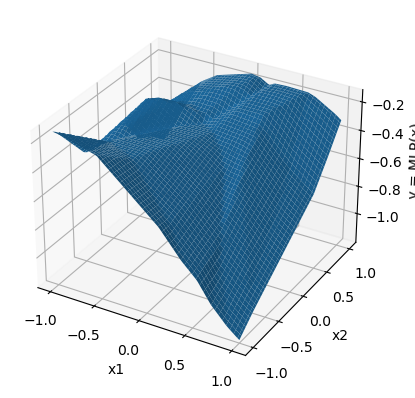

In [4]:
# Test our MLP function by graphing the function f:R2 -> R1

# Define some test points in R2
xs1 = np.linspace(-1, 1, 100)
xs2 = np.linspace(-1, 1, 100)

xs1, xs2 = np.meshgrid(xs1, xs2)

# Initialize the weights and biases
Ws, bs = init_params(input_dim, output_dim, L, N)

ys = []
for x in zip(xs1.flatten(), xs2.flatten()):
  x = np.array(x)
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)
ys = ys.reshape(xs1.shape)

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs1, xs2, ys)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y = MLP(x)')
plt.show()





**A note on functional vs. object-oriented programming**

In the above code, we defined our MLP purely using python functions. There is no neural network "object" with an internal state keeping track of the parameters. Instead, the parameters $W$ and $b$ are also treated as inputs to functions. This is *functional programming*, in which there are no objects with internal states that get modified. This is the approach to ML used by JAX.

It is also possible to define an MLP *class*, which is an object that contains the parameters as internal states that can potentially be modified, and methods that implement the model and evaluate $f(x)$. This is the approach to ML used by PyTorch and Tensorflow.

It is largely a matter of programming taste which you prefer. Below, we will see a brief example of the above code, but written in an object-oriented style rather than functional.

In [5]:
class My_MLP_Class():

  def __init__(self, input_dim, output_dim, L, N):

    # Initialize the network arguments
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.L = L
    self.N = N

    # Initialize the network internal state using the same initi function
    self.Ws, self.bs = init_params(input_dim, output_dim, L, N)

  def evaluate(self, x):

    # Just use the same exact function as above
    return MLP(x, self.Ws, self.bs)

  # "Magic Method" that lets us call the class as if it were a function (just syntatic magic)
  def __call__(self, x):

    return self.evaluate(x)


my_MLP = My_MLP_Class(input_dim, output_dim, L, N)

# Access the weights
my_weights = my_MLP.Ws
print("The number of layers is ",len(my_weights), ",Expected 3")

# Evaluate the function
print("f(1,1) = ", my_MLP(np.array([1, 1])))


The number of layers is  3 ,Expected 3
f(1,1) =  [-0.69961297]


**Historical Notes and Semantics**

The case where $L = 2$ (no ``hidden layers'' between the input and output) with the output dimensionality is $1$ is called a perceptron historically. These were introduced with $\sigma$ not as ReLU, but rather:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$
(the sigmoid function, hence the notation), and were used back in the day as a model of a biological neuron. The neuron "activates" (produces $1$) when $x$ is large, and "deactivates" (produces $0$ when $x$ is small, where $b$ is then a bias. For this reason, $\sigma$ is called an activation function. This is also why our models are called "Neural Networks". The "network" is because the parameters of the weight matrix $w_{ij}$ are drawn as lines connecting a node $i$ in the previous layer to a node $j$ in the next layer. It's important to remember though, that these are just affine transformations interleaved by some simple nonlinear functions, and there isn't really anything magic here, just slightly-nonlinear algebra.

The name "feedforward" network just refers to the function-compositional aspect of the model. It is to be contrasted with a "backwards pass", where derivatives with respect to the network are actually computed in reverse-order due to chain-rule simplifications. The name "dense" neural network is to emphasize that this is the simplest possible network one can build. There are many modern models with additional properties (such as gauranteeing symmetries, or working in spaces other than simple vector spaces, or deliberately constraining the function space), but many of these can be reduced to very large MLPs with constrained weights. When we say "dense" or "fully-conencted" MLPs, we typically mean there are no constraints on the parameters.



## Chapter 1.1: Universal Function Approximation

The power of MLPs is that they are an efficient way to parameterize a large class of functions. This is captured by the **Universal Function Approximation Theorem(s) (UFAT)** (there are lots of variants, but at the level of rigor we are working at, we won't worry about this).

**Emotionally**, the UFAT tells us that for sufficiently large $N$ and $L$, an MLP can approximate any (reasonable) $n$-to-$m$ dimensional function arbitrarily well.

**Slightly more precisely**, a version of UFAT says: For any piecewise-continuous function $f: \mathbb{R}^n \to \mathbb{R}^m$ defined on a compact domain $D \subset \mathbb{R}^n$, and for any "error tolerance" $\epsilon  > 0$, there exists a large enough $N$ and $L$ such that one can define an MLP with specially-chosen parameters $W$ and $b$ such that:
$$ \int_D dx |f(x) - MLP(x)| < \epsilon $$
i.e. that we have approximated the function to within the specified error.

[Side note: It is actually always possible to do this with just $L$ = 3 (meaning just one hidden layer with chosen $N$ in our defined $L$ counting), but typically this requires an exponentially large $N$ and isn't of practical use for what we will be doing].


We will not prove the UFAT. However, we will explore a weaker-version of it that is easier to understand: If instead we explore continuous-and-piecewise-once-differentiable functions rather than just piecewise-continuous, then there is an easy construction using ReLU networks. If a function is piecewise-once-differentiable, then it can be well-approximated by a piecewise-linear function. We will see below (as exercises) how ReLU networks can exactly reproduce piecewise linear functions.

###START_EXERCISE

#### EXERCISE: Modeling |x|

Given $f(x) = |x|$ in 1 dimension, design an MLP with a choice of N, L, weights W, and biases b that *exactly* match $f(x)$.

HINT: It is possible to do this with $L = 2$ (one hidden layer) and $N = 2$.

HINT 2: It is possible to do this with $b = 0$.



In [6]:
def f(x):
  return np.abs(x)


L = # YOUR SOLUTION HERE
N = # YOUR SOLUTION HERE

Ws = [] # YOUR SOLUTION HERE
bs = [] # YOUR SOLUTION HERE

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


SyntaxError: invalid syntax (3318753818.py, line 5)

###STOP_EXERCISE

###START_SOLUTION

In [ ]:
def f(x):
  return np.abs(x)


L = 2
N = 2

W0 = np.array([[ 1.0],      # hidden unit 1:  +x
               [-1.0]])     # hidden unit 2:  –x
b0 = np.array([0.0, 0.0])   # no shift

W1 = np.array([[1.0, 1.0]]) # add the two ReLU outputs
b1 = np.array([0.0,])        # no shift

Ws = [W0, W1]
bs = [b0, b1]

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


###STOP_SOLUTION

###START_EXERCISE

EXERCISE: Approximating a smooth 1D function.

Given $f(x) = \sin(10x) \exp(-2x^2)$ on the interval $[-1,1]$, design an MLP with ReLU-activations that approximates the function to within an error of $\epsilon < 0.01$ (where error is the mean-absolute error, as defined above). As a bonus, your implementation should be systematically improvable, e.g. it should be straightforward to make the MLP bigger to reduce the error further. Don't cheat and use minimization to get the parameters, explicitly construct them!


HINT: First construct a continuous piecewise linear appoximation to the function, then implement this piecewise linear function as an MLP. It is possible to do this without knowledge of the actual form of $f$.

HINT 2: This is possible to do systematically with $L = 2$ as before, but with a very large $N$. My personal solution requires $N$ between 100 and 150.

HINT 3: A peicewise-linear continuous function can be written as $f(x) = c_0 + m_0x + + \sum_{j = 1}^{n-1}(m_j - m_{j-1})\sigma(x - x_j)$, where $\sigma$ is ReLU, $x_{1}...x_{n-1}$ are the internal breakpoints, $m_j$ are the slopes to the right of each breakpoint, and $c_0$ is the $y$-coordinate at the leftmost point.




In [ ]:
def f(x):
  return np.sin(10*x) * np.exp(-2*x**2)

L = # YOUR SOLUTION HERE
N = # YOUR SOLUTION HERE
Ws = [] # YOUR SOLUTION HERE (hint, define a function to construct Ws, bs, systematically)
bs = [] # YOUR SOLUTION HERE


xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()

# Approximate the mean absolute error
print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs)))) #[:,0] due to annoying indexing


###STOP_EXERCISE

###START_SOLUTION

In [ ]:

# For any function f, define a piecewise-linear approximation with n breakpoints.
def piecewise_linear_params(n, f):

    # Breakpoints of the piecewise linear approximation
    xk = np.linspace(-1.0, 1.0, n + 1)          # x0, …, xn
    yk = f(xk)

    # Approximate the slopes numerically (technically, possible exactly)
    mk = np.diff(yk) / np.diff(xk)              # m0 … m_{n-1}

    # slope jumps delta_m_j at each breakpoint
    dm = mk[1:] - mk[:-1]

    # constant term that glues the first segment to y(-1)
    c0 = yk[0] - mk[0] * xk[0]

    # Initialize weights
    N = n + 1 # annoying indexing
    W0 = np.ones((N, 1))
    b0 = np.zeros(N)

    # Add and subtract a ReLU, like the |x| example
    W0[0, 0]  =  1.0 ;  b0[0]  = 0.0
    W0[1, 0]  = -1.0 ;  b0[1]  = 0.0

    # interior break-points
    for j, t_j in enumerate(xk[1:-1], start=2):   # j = 2 … n
        W0[j, 0] =  1.0
        b0[j]    = -t_j   # shift to next break point

    # Second layer where everything is just 1 and -1 to add and subtract
    W1 = np.zeros((1, N))
    W1[0, 0] =  mk[0]       #  +m0·ReLU(x)
    W1[0, 1] = -mk[0]       #  −m0·ReLU(−x)

    for j, d_m in enumerate(dm, start=2):
        W1[0, j] = d_m

    b1 = np.array([c0])  # constant offset for leftmost point


    Ws = [W0, W1]
    bs = [b0, b1]
    return Ws, bs


num_breakpoints = 100 # Increase for more accuracy!
Ws, bs = piecewise_linear_params(num_breakpoints, f)
xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs))))


###END_SOLUTION

## Chapter 1.2: Functional Optimization

We now have the ability to approximate function spaces with MLP's! The fun part of Machine Learning (the Learning) comes in when we can phrase problems as *functional optimization* problems:

"Out of all the (reasonably nice) functions from $\mathbb{R}^n \to \mathbb{R}^m$ , which function $f$ minimizes the loss functional $L[f]$?"

Almost every interesting problem in life, statistics, and physics can be phrased this way. In fact, this is completely identical to Lagrangian mechanics, in the case that $L[f]$ can be written as the integral of a local Lagrangian. In simple cases (ordinary classical mechanics) this functional optimization can be performed using the Euler-Lagrange equations. But in many cases (e.g. where $L[f]$ is written as a sum rather than an integral so EL does not apply, or we can't solve the EL equations, etc), we must settle for numerics.

You have seen in previous tutorials how many statistics problems (e.g. regression, classification, and density estimation) can be seen as functional optimization. In those examples, there were only a few parameters defining the function space: now there are *many* parameters and our function space is as close to the space of all possible functions as possible. We can no longer just use a simple parameter minimizer in this case.

The strategy will be **gradient descent**. If we have an estimate of:
$$\nabla_{\theta}L[f]$$
then by simply moving $\theta$ in the opposite direction of the gradient, we will move towards a local minimum. The process of iterating this is called **training**, and each iteration is called an **epoch**. In statistical settings, where $L[f]$ is some statistical measure (like in the regression examples), this training requires data to obtain statistical estimates of $\nabla_{\theta}L[f]$, hence the need for **training data**. There are many variants of gradient descent that work on the same principle but have varying numerical properties, like stochastic gradient descent and ADAM, but we will not dive deeper into these here.

In principle, if we know $L$ (which we usually do, because it is typically part of the problem specification), we can explictly construct $\nabla_{\theta}L[f]$ exactly, since we know how $f$ depends on our parameters $\theta = (W, b)$. However, it is still painful to manually construct. This is where libraries like **JAX**, **PyTorch**, and **Tensorflow** come in. These libraries are capable of **autodifferentiation**: computations are kept track of in a graph structure, so that gradients can be easily and exactly computed alongside the execution of the function. Exploring this further will be the subject of another tutorial, for now we wil take it for granted that these libraries can perform autodifferentiation.

We have reached the limit of what we can practically do without the use of libraries in a reasonable amount of time. Now, we will explore how to use these libraries.


# Interlude: The problems we will solve:

We will be interested in using Neural Networks to solve classification problems. We have previously seen how to do this with logistic regression and cross-entropies in the [classification tutorial](https://colab.research.google.com/github/mcgen-ct/tutorials/blob/main/ml/classification.ipynb). We will now see how to do this with Neural Networks.

We will have two problems: an easy problem, and a hard problem. The easy problem is "Two Moons", a classic ML test case in 2 dimensions. The hard problem is the "MNIST" dataset, a dataset of handwritten digits that is commonly used to test classification algorithms. This is a 28x28 pixel image dataset, so the input dimension is 784, so MLPs can really shine compared to classical fixed-form regressors.

In [7]:
from sklearn.datasets import make_moons, fetch_openml
from sklearn.preprocessing import StandardScaler

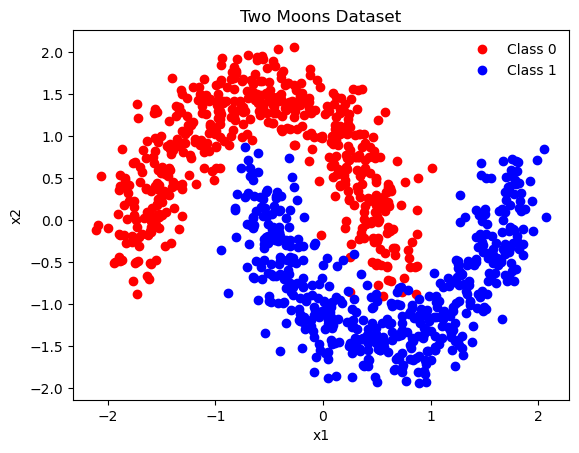

In [11]:
# Two Moons Dataset

X_moons, y_moons = make_moons(1024, noise=0.15, random_state=0)
X_moons = StandardScaler().fit_transform(X_moons) # Just normalizing the data

plt.plot(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], 'ro', label='Class 0')
plt.plot(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], 'bo', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Two Moons Dataset')
plt.legend(frameon = False)

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


MNIST dataset loaded with shape: (70000, 784)


Text(0.5, 1.0, 'Example MNIST Digit (7)')

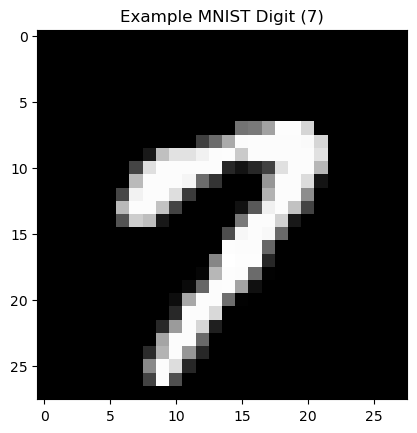

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist.data / 255.0  # Normalize pixel values to [0, 1]
y_mnist = mnist.target.astype(int)  # Convert target to integers

# The MNIST input dimension is 784, but we can visualize it as 28x28 images
plt.imshow(X_mnist[y_mnist == 7][0].reshape(28, 28), cmap='gray')
plt.title('Example MNIST Digit (7)')


# Chapter 2: JAX

JAX is a library developed by Google that is very similar to numpy, but with some extra features that make it useful for machine learning. It is based on the idea of functional programming, where functions are first-class citizens and can be passed around like any other object. JAX is particularly useful for machine learning because it has built-in support for autodifferentiation, which allows us to compute gradients of functions with respect to their inputs.

Compared to PyTorch and Tensorflow, JAX is more low-level and requires more manual work to set up. However, it is also more flexible and allows for more control over computations. JAX is particularly useful for research and experimentation, where you want to try out new ideas quickly without having to worry about the details of the implementation.



In [17]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import time

## Chapter 2.1: JAX basics; vmapping, autodifferentiation, and compilation.

JAX has three useful features that we should be aquainted with:


1.   Vmapping: We can write a function acting on a single variable, and then execute that function on an entire list at once without using loops. In fact, this is much faster than looping (in Python), since Python loops must wait for the previous iteration to finish. Note that numpy can technically do this too, but it becomes especially important in JAX
2.   Just-In-Time compilation (JIT): Python is a scripted language, meaning lines of code are carried out as your computer sees them. In compiled languages, the computer looks at the entire program, translates to machine code (compilation), then executes. You pay an up-front time cost for the initial compilation, but every subsequent execution is much faster since the machine code is typically highly optimized. JIT allows us to pre-compile functions in Python. The cost is that we have to be a little be conscious of things like memory, and we cannot use things like ordinary if-statements or for-loops.
3. Autodifferentiation: If we write a function in JAX, we can automatically compute its exact derivative. We don't have to manually compute it ourselves! This even works with multi-variate functions, functions that are highly-composed and require lots of chain-ruling, etc.



Loop time:  0.9748046398162842
Vmap time:  0.002240896224975586
Compilation time:  0.011830329895019531
JIT loop time:  0.8590126037597656
JIT vmap time:  0.019756793975830078


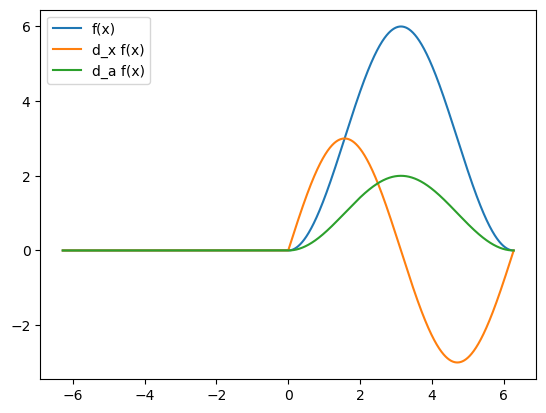

In [26]:
def relu(x):
  return jnp.maximum(0, x)

def theta(x):
  return (x > 0)

def f(x, a):
  return a * (1 - jnp.cos(x)) * theta(x)

a = 3.0
xs = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 10000)

# Vmapping time save test:
start_time = time.time()
ys = []
for x in xs:
  ys.append(f(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("Loop time: ", end_time - start_time)

start_time = time.time()

# vmap(f) is a new function with the same signature as f.
# vmap(f, in_axes = (0, None)) means we only want to vectorize over the first argument (x), not the second.

ys = vmap(f, in_axes = (0, None))(xs, a)
end_time = time.time()
print("Vmap time: ", end_time - start_time)


# Compile the function
start_time = time.time()
f_jit = jit(f)
f_jit(0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"
end_time = time.time()
print("Compilation time: ", end_time - start_time)
# Note that compilation is NOT always faster, especially for only simple functions.
# Also machine-dependent!


start_time = time.time()
ys = []
for x in xs:
  ys.append(f_jit(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("JIT loop time: ", end_time - start_time)

start_time = time.time()
ys = vmap(f_jit, in_axes=(0, None))(xs, a)
end_time = time.time()
print("JIT vmap time: ", end_time - start_time)



# Get the exact gradient with respect to x
f_prime = jax.grad(f, argnums=0) # Argnums is the argument we want the gradient of.
f_prime_jit = jit(f_prime)
f_prime_jit(0.0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"

# Get the exact gradient with respect to a
f_prime_a = jax.grad(f, argnums=1) # Argnums is the argument we want the gradient of.
f_prime_a_jit = jit(f_prime_a)


plt.plot(xs, vmap(f_jit, in_axes=(0, None))(xs, a), label='f(x)')
plt.plot(xs, vmap(f_prime_jit, in_axes=(0, None))(xs, a), label='d_x f(x)')
plt.plot(xs, vmap(f_prime_a_jit, in_axes=(0, None))(xs, a), label='d_a f(x)')
plt.legend()
plt.show()



## Chapter 2.2: End-to-End MLP and Training from Scratch

First, let's reproduce the MLP we defined above, but now using JAX. We will use the functional programming style, so we will define our MLP as a function that takes in the parameters $W$ and $b$ as inputs.

A small difference is that rather than having W and b as separate inputs, we will combine them into a single input called `params`. This is just for convenience to make taking gradients cleaner. Also, since we are interested in classification, we will use a sigmoid activation for the last layer in the binary classification case to ensure the output is between 0 and 1, which is useful for classification tasks, and use a softmax for the multiclass case.

In [77]:
# JAX MLP. Basically identical to the above numpy code.
def MLP_jax(x, params):
    y = x
    Ws, bs = params

    for l in range(len(Ws) - 1):
        y = jnp.dot(Ws[l], y) + bs[l]
        y = relu(y)

    y = jnp.dot(Ws[-1], y) + bs[-1]  # No activation on the last layer

    return y

# Our classifier will be an MLP with a sigmoid at the end. Change to softmax for multi-class classification.
def classifier(x, params):

    # Its common to call the input to the sigmoid the "logits". But really its the log-likelihood ratio of the classes.
    logits = MLP_jax(x, params)
    return 1 / (1 + jnp.exp(-logits))  


# Gradient with respect to the parameters
classifier_grad = grad(classifier, argnums=1)  


# Initialize the parameters for the MLP
def init_params_jax(input_dim, output_dim, L, N):
    Ws = []
    bs = []

    for l in range(L):
        if l == 0:

            # Basically the same as the numpy version, but using JAX's random module.
            # Unlike numpy, JAX's random module is functional and requires a PRNG key.
            W = random.normal(random.PRNGKey(l), (N, input_dim)) / jnp.sqrt(input_dim) 
            b = random.normal(random.PRNGKey(l + 1), (N,)) / jnp.sqrt(input_dim)
        elif l == L - 1:
            W = random.normal(random.PRNGKey(l), (output_dim, N)) / jnp.sqrt(N) 
            b = random.normal(random.PRNGKey(l + 1), (output_dim,)) 
        else:
            W = random.normal(random.PRNGKey(l), (N, N)) / jnp.sqrt(N) 
            b = random.normal(random.PRNGKey(l + 1), (N,)) 

        Ws.append(W)
        bs.append(b)

    return Ws, bs

Shape of xs:  (10000, 2)


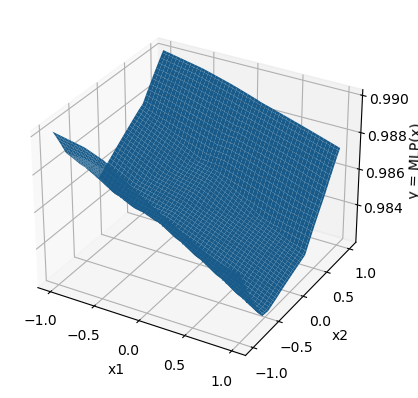

In [ ]:
# Test just to make sure it works

N = 16
L = 3
input_dim = 2
output_dim = 1

xs1 = jnp.linspace(-1, 1, 100)
xs2 = jnp.linspace(-1, 1, 100)

xs1, xs2 = jnp.meshgrid(xs1, xs2)
xs = jnp.array(list(zip(xs1.flatten(), xs2.flatten())))
print("Shape of xs: ", xs.shape)  # Should be (10000, 2)

# Initialize the weights and biases
Ws, bs = init_params_jax(input_dim, output_dim, L, N)

# VMAP our model. We can also JIT it, but its actually better to JIT the entire training step function later.
vmapped_classifier = vmap(classifier, in_axes=(0, None))
vmapped_classifier_grads = vmap(classifier_grad, in_axes=(0, None))

ys = vmapped_classifier(xs, (Ws, bs))
ys = ys.reshape(xs1.shape)

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs1, xs2, ys)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y = MLP(x)')
plt.show()


Now we set up the training. We want to minimize the cross-entropy loss function, which is defined as:
$$ L[f] = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(f(x_i)) + (1 - y_i) \log(1 - f(x_i)) $$

where $y_i$ is the true label for the $i$-th data point, and $f(x_i)$ is the model score for the $i$-th data point.

We will use JAX's autodifferentiation to compute the gradient of the loss function with respect to the parameters, and then use gradient descent to update the parameters.

<!- -->

In [ ]:
# Define the BCE loss
def bce_loss(x, y_true, params):

    y_pred = vmapped_classifier(x, params).squeeze()
    epsilon = 1e-10  # Small value to avoid log(0), just in case
    return -jnp.mean(y_true * jnp.log(y_pred + epsilon) + (1 - y_true) * jnp.log(1 - y_pred + epsilon))


grad_bce_loss = grad(bce_loss, argnums=2)  # Gradient with respect to the parameters


# Gradient step function to update the parameters
@jit  # <- Inline way to JIT the function
def gradient_step(x, y_true, params, learning_rate=0.01):

    # Compute the loss gradients (the loss itself is not needed, just the gradients)
    loss = bce_loss(x, y_true, params) # But we will compute it anyways for logging
    grads = grad_bce_loss(x, y_true, params)

    # Update the parameters using gradient descent
    Ws, bs        = params
    dWs, dbs      = grads
    new_Ws = [W - learning_rate*dW for W, dW in zip(Ws, dWs)]
    new_bs = [b - learning_rate*db for b, db in zip(bs, dbs)]
    new_params = (new_Ws, new_bs)    

    return new_params, loss


# ##### Train the model on the Two Moons dataset #####

# Set the random seed for reproducibility
train_fraction = 0.8
test_fraction = 1- train_fraction
epochs = 2000
learning_rate = 0.1
N = 8 # Its nice to choose N ~ 2^n, since differences in width are only really important on log scale
L = 3

# Split the dataset into training and testing sets
train_size = int(train_fraction * len(X_moons))

# Ensure the dataset is shuffled before splitting
# [Just for fun, try removing this part and see how badly things get ruined]
indices = np.random.permutation(len(X_moons)) 
X_moons = X_moons[indices]
y_moons = y_moons[indices]
X_train, y_train = X_moons[:train_size], y_moons[:train_size]
X_test, y_test = X_moons[train_size:], y_moons[train_size:] 

# Initialize the parameters
params = init_params_jax(input_dim, output_dim, L, N)

# Arrays for saving training info
train_losses = []
test_losses = []

# Train the model
for epoch in range(epochs):

    # Perform a gradient step
    params, loss = gradient_step(X_train, y_train, params, learning_rate)
    train_losses.append(loss)
    # Evaluate on the test set
    test_loss = bce_loss(X_test, y_test, params)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 0, Loss: 0.8859, Test Loss: 0.9369
Epoch 10, Loss: 0.6576, Test Loss: 0.6870
Epoch 20, Loss: 0.5055, Test Loss: 0.4901
Epoch 30, Loss: 0.4071, Test Loss: 0.3714
Epoch 40, Loss: 0.3537, Test Loss: 0.3121
Epoch 50, Loss: 0.3239, Test Loss: 0.2806
Epoch 60, Loss: 0.3071, Test Loss: 0.2633
Epoch 70, Loss: 0.2973, Test Loss: 0.2531
Epoch 80, Loss: 0.2913, Test Loss: 0.2466
Epoch 90, Loss: 0.2873, Test Loss: 0.2421
Epoch 100, Loss: 0.2844, Test Loss: 0.2389
Epoch 110, Loss: 0.2821, Test Loss: 0.2364
Epoch 120, Loss: 0.2802, Test Loss: 0.2342
Epoch 130, Loss: 0.2784, Test Loss: 0.2324
Epoch 140, Loss: 0.2768, Test Loss: 0.2307
Epoch 150, Loss: 0.2753, Test Loss: 0.2292
Epoch 160, Loss: 0.2738, Test Loss: 0.2279
Epoch 170, Loss: 0.2725, Test Loss: 0.2267
Epoch 180, Loss: 0.2711, Test Loss: 0.2255
Epoch 190, Loss: 0.2698, Test Loss: 0.2244
Epoch 200, Loss: 0.2684, Test Loss: 0.2232
Epoch 210, Loss: 0.2670, Test Loss: 0.2219
Epoch 220, Loss: 0.2655, Test Loss: 0.2207
Epoch 230, Loss: 0.263

Shape of xs for contour plot:  (10000, 2)


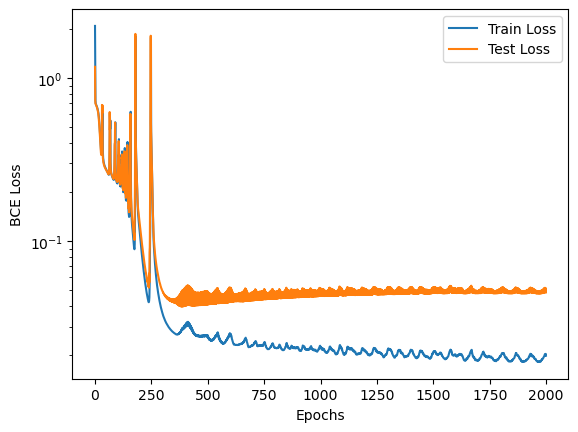

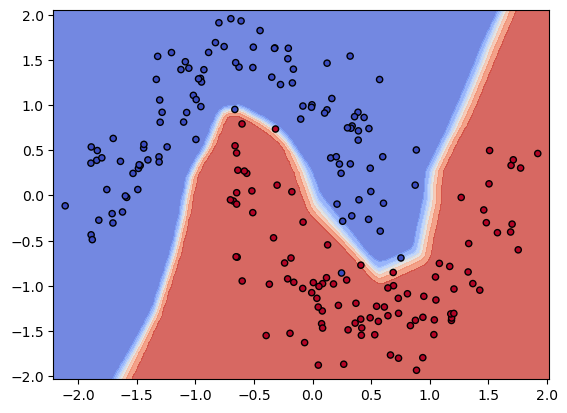

In [94]:
# Plot our answers!

# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()

# Plot the decision boundary
fig, ax = plt.subplots()
x_min, x_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1
y_min, y_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1
xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 100), jnp.linspace(y_min, y_max, 100))
xs = jnp.array(list(zip(xx.ravel(), yy.ravel())))
print("Shape of xs for contour plot: ", xs.shape)  # Should be (10000, 2)
Z = vmap(classifier, in_axes=(0, None))(xs, params)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')      
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='o', s=20, cmap='coolwarm')

Congrats! You have coded an MLP from scratch and trained it!

###START_EXERCISE

EXERCISE 2.1: Ruining the Model.

In this exercise, we will deliberate try to break the model. The goal here is to get a little experience with failure modes.

Try to deliberately overfit the model. You have a few knobs to play with: The depth $L$, the width $N$, the learning rate, the number of epochs, and the amount of training data. Try to find a combination of these that overfits the training data, i.e. the training loss is very low but the validation loss is high.

Try to see what happens if you forget to shuffle the data! This is a very common mistake.

Try extreme learning rates, like $10^{-6}$ or $10^{2}$. 

When we loaded in the data a few cells ago, we normalized the data. What happens if the data is not O(1)? Try arranging the data so that the inputs are all $O(10^6)$ or $O(10^{-6})$. Technically, the optimal classifier should be coordinate-invariant, but in practice there can be issues! Try some other coordinate transforms of the data too.





###STOP_EXERCISE

###START_SOLUTION

Everything else unchanged, choosing $N \gtrapprox 32$ and $L \gtrapprox 8$ will overfit the training data. There are many other options though!

###STOP_SOLUTION

###START_EXERCISE

EXERCISE 2.2: MNIST With our JAX MLP

Modify the above code to classify MNIST. You will need to change the loss function and the output activation to account for the fact that MNIST is a multi-class classification problem. 


Epoch 0, Loss: 3.1037, Test Loss: 2.8763, Accuracy: 0.0961
Epoch 10, Loss: 2.0962, Test Loss: 2.0605, Accuracy: 0.2801
Epoch 20, Loss: 1.7783, Test Loss: 1.7659, Accuracy: 0.4649
Epoch 30, Loss: 1.5531, Test Loss: 1.5481, Accuracy: 0.5319
Epoch 40, Loss: 1.3734, Test Loss: 1.3713, Accuracy: 0.6031
Epoch 50, Loss: 1.2166, Test Loss: 1.2147, Accuracy: 0.6661
Epoch 60, Loss: 1.0723, Test Loss: 1.0693, Accuracy: 0.7182
Epoch 70, Loss: 0.9372, Test Loss: 0.9338, Accuracy: 0.7584
Epoch 80, Loss: 0.8187, Test Loss: 0.8159, Accuracy: 0.7886
Epoch 90, Loss: 0.7239, Test Loss: 0.7221, Accuracy: 0.8106
Epoch 100, Loss: 0.6514, Test Loss: 0.6506, Accuracy: 0.8261
Epoch 110, Loss: 0.5961, Test Loss: 0.5958, Accuracy: 0.8402
Epoch 120, Loss: 0.5530, Test Loss: 0.5528, Accuracy: 0.8526
Epoch 130, Loss: 0.5187, Test Loss: 0.5187, Accuracy: 0.8621
Epoch 140, Loss: 0.4910, Test Loss: 0.4911, Accuracy: 0.8692
Epoch 150, Loss: 0.4682, Test Loss: 0.4685, Accuracy: 0.8748
Epoch 160, Loss: 0.4495, Test Loss:

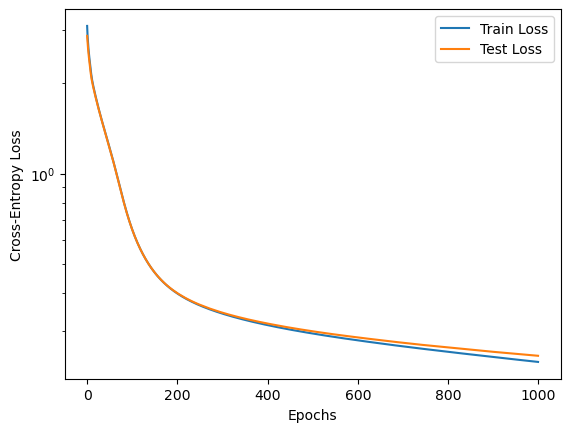

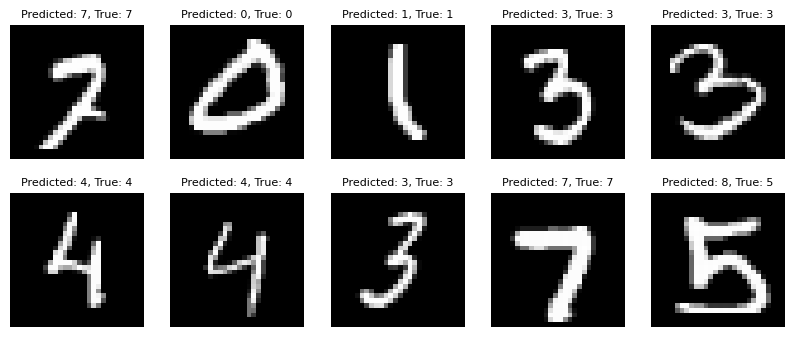

In [101]:
# Prepare the MNIST Dataset
train_fraction = 0.8
test_fraction = 1 - train_fraction

# Shuffle the dataset before splitting
indices = np.random.permutation(len(X_mnist))
X_mnist = X_mnist[indices]
y_mnist = y_mnist[indices]
train_size = int(train_fraction * len(X_mnist))
X_train_mnist, y_train_mnist = X_mnist[:train_size], y_mnist[:train_size]       
X_test_mnist, y_test_mnist = X_mnist[train_size:], y_mnist[train_size:]

def one_hot_encode(y, num_classes):
    return jax.nn.one_hot(y, num_classes)

input_dim = 784  # MNIST images are 28x28 pixels, flattened to 784
output_dim = 10  # 10 classes for digits 0-9


# --- The rest of your code here ---


###STOP_EXERCISE

###START_SOLUTION

In [ ]:
# Prepare the MNIST Dataset
train_fraction = 0.8
test_fraction = 1 - train_fraction

# Shuffle the dataset before splitting
indices = np.random.permutation(len(X_mnist))
X_mnist = X_mnist[indices]
y_mnist = y_mnist[indices]
train_size = int(train_fraction * len(X_mnist))
X_train_mnist, y_train_mnist = X_mnist[:train_size], y_mnist[:train_size]       
X_test_mnist, y_test_mnist = X_mnist[train_size:], y_mnist[train_size:]

def one_hot_encode(y, num_classes):
    return jax.nn.one_hot(y, num_classes)

input_dim = 784  # MNIST images are 28x28 pixels, flattened to 784
output_dim = 10  # 10 classes for digits 0-9


# YOUR PARAMETERS HERE
epochs = 1000
learning_rate = 0.1
N = 16
L = 3

# YOUR MODIFIED CLASSIFIER HERE
classifier_mnist = lambda x, params: jax.nn.softmax(MLP_jax(x, params))
vmapped_classifier = vmap(classifier_mnist, in_axes=(0, None))

# YOUR MULTICLASS LOSS FUNCTION HERE
def multiclass_cross_entropy_loss(x, y_true, params):
    y_pred = vmapped_classifier(x, params)
    epsilon = 1e-10  # Small value to avoid log(0)
    return -jnp.mean(jnp.sum(y_true * jnp.log(y_pred + epsilon), axis=1))

# YOUR TRAINING LOOP HERE
params_mnist = init_params_jax(input_dim, output_dim, L, N)
train_losses_mnist = []
test_losses_mnist = []  

@jit
def gradient_step_mnist(x, y_true, params, learning_rate=0.01):
    loss = multiclass_cross_entropy_loss(x, y_true, params)
    grads = grad(multiclass_cross_entropy_loss, argnums=2)(x, y_true, params)

    Ws, bs = params
    dWs, dbs = grads
    new_Ws = [W - learning_rate * dW for W, dW in zip(Ws, dWs)]
    new_bs = [b - learning_rate * db for b, db in zip(bs, dbs)]
    new_params = (new_Ws, new_bs)

    return new_params, loss



# Train the model
for epoch in range(epochs):
    params_mnist, loss = gradient_step_mnist(X_train_mnist, one_hot_encode(y_train_mnist, output_dim), params_mnist, learning_rate)
    train_losses_mnist.append(loss)
    test_loss = multiclass_cross_entropy_loss(X_test_mnist, one_hot_encode(y_test_mnist, output_dim), params_mnist)
    test_losses_mnist.append(test_loss)

    # compute the accuracy
    y_pred = jnp.argmax(vmap(classifier_mnist, in_axes=(0, None))(X_test_mnist, params_mnist), axis=1)
    accuracy = jnp.mean(y_pred == y_test_mnist)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")



# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses_mnist, label='Train Loss')
plt.plot(test_losses_mnist, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

# Plot some predictions
fig, ax = plt.subplots(2, 5, figsize=(10, 4))   
for i in range(10):
    ax[i // 5, i % 5].imshow(X_test_mnist[i].reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Predicted: {jnp.argmax(classifier_mnist(X_test_mnist[i], params_mnist))}, True: {y_test_mnist[i]}", fontsize=8)
    ax[i // 5, i % 5].axis('off')





###STOP_SOLUTION

## Chapter 2.3: Using Prebuilt ML Modules

We have seen how to build an ML model from scratch in JAX. This is no different than building an ordinary functional model: we create a parameterized function, and then optimize the parameters to minimize some loss function. The only difference is that our function has a lot of parameters and is specified by repeated function composition of layers, and that our minimization is done using gradient descent rather than a simple parameter minimizer.

However, sometimes we don't want to build models from scratch, and let other people do the work for us. In this case, we can use prebuilt modules that implement common ML models. There is a library called `flax` built on top of JAX that provides a set of prebuilt modules for common ML tasks, including MLPs. It also provides many useful utilities for training and evaluating models, such as optimizers, pre-built loss functions, specialzied layers, advanced training techniques like dropout and batch normalization, and modern models. This code also will also likely be more optimized than our hand-written code!

In [105]:
import flax
from flax import nnx

ImportError: cannot import name 'nnx' from 'flax' (/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/flax/__init__.py)

In [ ]:

from jax.example_libraries import stax
init, apply = stax.serial(
    stax.Dense(32), stax.Relu,
    stax.Dense(32), stax.Relu,
    stax.Dense(1)
)
key, sub = random.split(key)
_, p = init(sub, (-1,2))

def loss(p,x,y):
    logits = jnp.squeeze(apply(p,x))
    return -jnp.mean(y*jax.nn.log_sigmoid(logits)+(1-y)*jax.nn.log_sigmoid(-logits))

@jit
def step(p,x,y,lr=0.05):
    g = grad(loss)(p,x,y)
    return jax.tree_util.tree_map(lambda a,b: a-lr*b, p, g)

for _ in range(300):
    p = step(p,X,y)

print("stax loss:", loss(p,X,y))


# Chapter 3: PyTorch

PyTorch is a popular ML library developed by Meta (formerly Facebook). It is widely used in industry and research. It is typically more high-level than JAX, and has a wider range of prebuilt modules and utilities for common ML tasks. It is also older and more widely supported with documentation and tutorials online. 

Unlike JAX, PyTorch is object-oriented, meaning that we will define an MLP as a class with an internal state that keeps track of the parameters. 



In [106]:
import torch, torch.nn as nn
device='cuda' if torch.cuda.is_available() else 'cpu'

Primer: PyTorch tensors

PyTorch has its own tensor class, which are similar to (but not the same as) numpy arrays. They can live on a "device" (e.g. `cuda` or `cpu`), and can be used to perform computations on that device. PyTorch tensors have many of the same methods as numpy arrays, but also have some additional methods for ML tasks, such as `backward()` for computing gradients.

Autodiff in PyTorch is different than in JAX. In PyTorch, we define a computation graph by performing operations on tensors, and then call `backward()` on the output tensor to compute the gradients. This is different from JAX, where we define a function and then call `grad()` on that function to compute the gradients. Once a tensor is in the graph, it cannot be converted back to numpy without first `detach`ing it. 

To emphasize, in JAX, we take derivatives of functions, and the derivative of a function is another function. In PyTorch, we tell the graph to keep track of a tensor, we pass the tensor through a function, and then we ``backpropagate'' the resultant tensor. Derivatives are computed on the output tensor and the result is a tensor. 

Gradient at x=0.0:  10.0


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

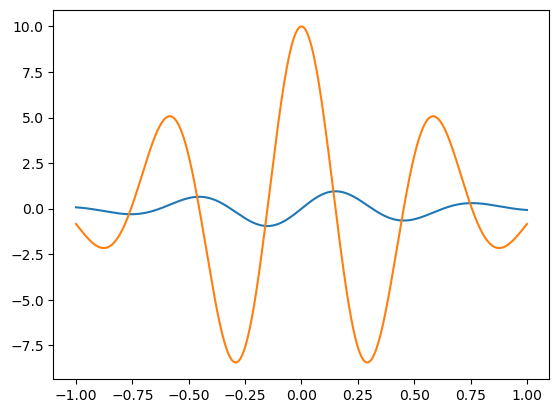

In [122]:

# A pytorch tensor defined from our numpy moons dataset
x_pytorch = torch.tensor(X_moons, dtype=torch.float32, device=device)

# Converting the pytorch tensor back to a numpy tensor 
x_numpy = x_pytorch.numpy()  


##### DEFINING GRADIENTS AND COMPUTATION GRAPHS ######

# Define a function and compute gradients
def f_torch(x):
    return torch.sin(10*x) * torch.exp(-2*x**2)


# requires_grad=True to compute gradients later! Try setting to False and see what happens!

x_single = torch.tensor([0.0], device=device, requires_grad=True)  # Single value tensor
y_single = f_torch(x_single)  # Compute the function value




# We want to compute the gradient of the function and plot it.
# First, we call .backward on the output of the function (not the function itself!).
# This tells Pytorch its time to compute the gradients in the computational graph.

y_single.backward()  # Compute the gradient for the single value

# Now the gradients are computed. To access it, we use .grad() on the input tensor.
print("Gradient at x=0.0: ", x_single.grad.item())  # Should print the gradient at x=0.0



##### MULTIPLE INPUTS ######

# The same as above, but now on a vectorized input
xs = torch.linspace(-1, 1, 1000, device=device, requires_grad=True)  
ys = f_torch(xs)

# We cannot just use ys.backward() because ys is a vector, not a scalar.
# ys has 1000 elements, and xs has 1000 elements, so PyTorch thinks there is a 1000 x 1000 jacobian!
# We need to specify a gradient direction to sum the gradients over the output dimension. Since y_j is indepndent of x_i for i!=j, we can just use a vector of ones as the gradient direction.
gradient_direction = torch.ones_like(ys, device=device)  # 
ys.backward(gradient=gradient_direction)  # Compute the gradients
# Now we can access the gradients
xs_grad = xs.grad  # This will be a tensor of the same shape as xs in the specified direction.


# Plot the function and its gradient
plt.plot(xs.detach().numpy(), ys.detach().numpy(), label='f(x)')
plt.plot(xs.detach().numpy(), xs_grad, label='f\'(x)')


# Zero-ing out gradients
# In PyTorch, gradients accumulate by default, so we need to zero them out before the next backward pass.
x_single.grad.zero_()  # Zero out the gradients
xs.grad.zero_()  # Zero out the gradients


## Chapter 3.1: Pre-built PyTorch Modules

The `Sequential` class

There are many possible layers of abstraction in PyTorch. The highlest-level, "I don't care, I just want a neural network, don't bother me with details" way to define an MLP is to use the `Sequential` class. 

Most models are simply a sequence of layers, where each layer is a function that takes in the output of the previous layer and produces an output. The `Sequential` class allows us to define a model as a sequence of layers, where each layer is applied in order. The ``nn` module provides many prebuilt layers, such as `Linear`, `ReLU`, and `Softmax`, that can be used to define a model. Note that `Linear` actually means "Affine", i.e. it implements the affine transformation $W x + b$.

Let's see how to implement an MLP. Compared to the above implementations, this will be much shorter and cleaner, since most of this is already implemented for us in PyTorch (but the cost is that we have less control over the details of the implementation, like if we wanted to mess with layer weights). Note that we don't even have to worry about the initialization of the weights, since PyTorch does this for us automatically.

We also don't have to bother defining a loss function or gradient descent, sice this also already exists.

In [ ]:
input_dim = 2
output_dim = 1


model = nn.Sequential(
    nn.Linear(input_dim,32), nn.ReLU(),
    nn.Linear(32,32), nn.ReLU(), # We just stack a bunch of layers
    nn.Linear(32,output_dim)  # No activation on the last layer. Instead, we'll put the sigmoid or softmax in the loss function..
).to(device) # .to(device) moves the model to the GPU if available


# Lots of optimizers to choose from! SGD is ordinary (stochastic) gradient descent, Adam is a more advanced optimizer.
opt_sgd = torch.optim.SGD(model.parameters(), lr=1e-2) 
opt_adam = torch.optim.Adam(model.parameters(), lr=1e-2)


# Prebuilt BCE. Already includes the sigmoid, so we don't need to apply it in the model.
loss_fn = nn.BCEWithLogitsLoss()




In [ ]:
# Train the model
epochs = 300
train_fraction = 0.8
opt = opt_adam  # Choose the optimizer

X_torch = torch.tensor(X_moons, dtype=torch.float32, device=device)
y_torch = torch.tensor(y_moons, dtype=torch.float32, device=device).unsqueeze(1)  # Unsqueeze to make it a column vector

# Training/test split, shuffle the dataset
train_size = int(train_fraction * len(X_torch))
indices = torch.randperm(len(X_torch))  # Shuffle the dataset
X_torch = X_torch[indices]
y_torch = y_torch[indices] 
X_train, y_train = X_torch[:train_size], y_torch[:train_size]
X_test, y_test = X_torch[train_size:], y_torch[train_size:]


train_losses = []
test_losses = []

for _ in range(300):


    opt.zero_grad() # Zero out the gradients before the backward pass. VITAL!
    loss = loss_fn(model(X_train), y_train)
    loss.backward() # Tell the graph its time to compute the gradients
    opt.step() # "step" automatically updates the parameters using the gradients computed in the backward pass
    train_losses.append(loss.item())  # Save the training loss
    test_loss = loss_fn(model(X_test), y_test)
    test_losses.append(test_loss.item())  # Save the test loss
    if _ % 10 == 0:
        print(f"Epoch {_}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

print("PyTorch loss:", loss.item())

Epoch 0, Train Loss: 0.7058, Test Loss: 0.7116
Epoch 10, Train Loss: 0.6932, Test Loss: 0.6986
Epoch 20, Train Loss: 0.6812, Test Loss: 0.6864
Epoch 30, Train Loss: 0.6698, Test Loss: 0.6747
Epoch 40, Train Loss: 0.6588, Test Loss: 0.6635
Epoch 50, Train Loss: 0.6480, Test Loss: 0.6525
Epoch 60, Train Loss: 0.6374, Test Loss: 0.6417
Epoch 70, Train Loss: 0.6268, Test Loss: 0.6310
Epoch 80, Train Loss: 0.6163, Test Loss: 0.6203
Epoch 90, Train Loss: 0.6057, Test Loss: 0.6096
Epoch 100, Train Loss: 0.5950, Test Loss: 0.5990
Epoch 110, Train Loss: 0.5843, Test Loss: 0.5882
Epoch 120, Train Loss: 0.5735, Test Loss: 0.5774
Epoch 130, Train Loss: 0.5626, Test Loss: 0.5666
Epoch 140, Train Loss: 0.5517, Test Loss: 0.5558
Epoch 150, Train Loss: 0.5408, Test Loss: 0.5450
Epoch 160, Train Loss: 0.5300, Test Loss: 0.5343
Epoch 170, Train Loss: 0.5193, Test Loss: 0.5237
Epoch 180, Train Loss: 0.5087, Test Loss: 0.5133
Epoch 190, Train Loss: 0.4983, Test Loss: 0.5030
Epoch 200, Train Loss: 0.4882, 

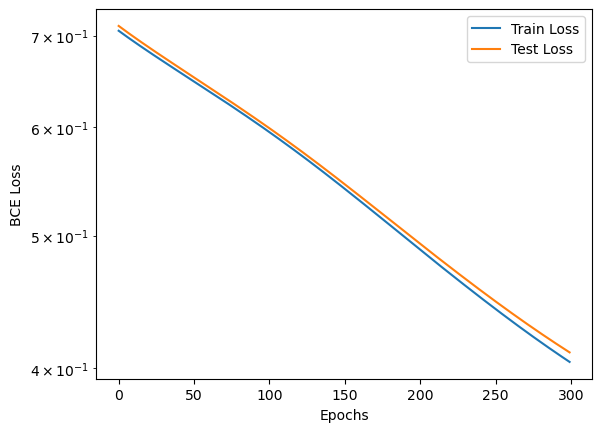

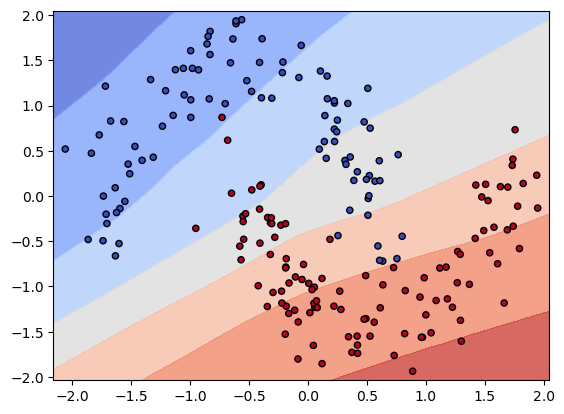

In [ ]:
# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()

# Plot the decision boundary
fig, ax = plt.subplots()
x_min, x_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1   
y_min, y_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
xs = torch.stack([xx.ravel(), yy.ravel()], dim=1).to(device)  # Stack to create a grid of points
Z = model(xs)  # Get the model predictions


# Dont forget to apply the sigmoid to the logits!
Z = torch.sigmoid(Z)  # Apply sigmoid to the logits

Z = Z.detach().cpu().numpy()
Z = Z.reshape(xx.shape)  # Reshape to match the grid shape
ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, alpha=0.8, cmap='coolwarm')
ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), edgecolors='k', marker='o', s=20, cmap='coolwarm')
plt.show()

###START_EXERCISE

EXERCISE 3.1: 

Now that we don't have to code anything, lets try some more advanced things.
1) Compare the ADAM optimizer to the SGD optimizer. 
2) Trade out the ReLU activation for sigmoid (used in the original MLP's back in the day), selu (a variant of ReLU that doesn't go to 0), and others. How do they compare? The modern lore in 2025 is to use "Swish" (aka "SiLU") activations, which are supposedly better than ReLU. There are many more at https://docs.pytorch.org/docs/main/nn.functional.html#non-linear-activation-functions. Try them out!
3) PyTorch MLP layers are called "Linear" despite being affine transformations. Let's see what happens if they are literally linear: the bias term can be removed with `bias=False`, e.g. `nn.Linear(32,32, bias = False)`. What happens to the decision boundary? As you do this, reflect on the exercise we did earlier where we constructed MLPs to exactly match piecewise linear functions, and the role the bias played there.
4) It should be straightforward to change the model to work on MNIST.


###STOP_EXERCISE

## Chapter 3.2 (BONUS): Convolutional Neural Networks (CNNs)

MLP's are already universal function approximators. But we can do better!

Often, and especially in physics, our function has some structure we can exploit (such as symmetries, or locality). Perhaps we can use this symmetry to constrain the weights of the MLP, or even better (and equivalently), design a new MLP-like-model that has this symmetry built in and is a universal function approximator with respect to this symmetry.

Image classification has an approximate translational symmetry: If an image of a handwritten "5" is shifted to the right, it is still a "5". We can exploit this symmetry by using a **Convolutional Neural Network (CNN)**, which is a type of neural network that is specifically designed for image classification tasks that has this translational symmetry built in. A CNN can achieve significantly better performance than an MLP with the same number or far fewer parameters.

A 2D translation on our 784-dimensional input space is a violent operation, and a generic MLP will not be translationlly invariant (or covariant). One can attempt to solve for a special class of $W$'s that are covariant (related to Toeplitz matrices), but this will end up being related to convolutions anyways. 

# Chapter 4: Tensorflow

TODO: TALK ABOUT KERAS/TF SPLIT

In [ ]:

import tensorflow as tf
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
y_tf = tf.expand_dims(tf.convert_to_tensor(y, dtype=tf.float32),1)

model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])
model_tf.fit(X_tf, y_tf, epochs=300, verbose=0)
print("TF loss, acc:", model_tf.evaluate(X_tf, y_tf, verbose=0))
